In [1]:
import sys
sys.path.insert(1, "/home/sgururaj/src/flow_graphs/code")
sys.path

['/home/sgururaj/src/flow_graphs',
 '/home/sgururaj/src/flow_graphs/code',
 '/home/sgururaj/src/flow_graphs/code/analysis_notebooks',
 '/home/sgururaj/.vscode-server/extensions/ms-toolsai.jupyter-2022.9.1303220346/pythonFiles',
 '/home/sgururaj/.vscode-server/extensions/ms-toolsai.jupyter-2022.9.1303220346/pythonFiles/lib/python',
 '/home/sgururaj/miniconda3/envs/amr/lib/python37.zip',
 '/home/sgururaj/miniconda3/envs/amr/lib/python3.7',
 '/home/sgururaj/miniconda3/envs/amr/lib/python3.7/lib-dynload',
 '',
 '/home/sgururaj/miniconda3/envs/amr/lib/python3.7/site-packages',
 '/home/sgururaj/miniconda3/envs/amr/lib/python3.7/site-packages/IPython/extensions',
 '/home/sgururaj/.ipython']

In [2]:
from collections import defaultdict, Counter
from collections import defaultdict as ddict
import itertools
import json
import pickle
import random

import dill
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from transformers import AutoTokenizer

from amr.inspection import get_type_paths_for_relation

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [4]:
datasets = ["risec", "japflow", "mscorpus"]

In [5]:
amr_content = {}
preprocessed_data = {}

for dataset in datasets:
    with open(f"data/{dataset}/amr_train.pkl", "rb") as f:
        amr_content[dataset] = pickle.load(f)

    with open(f"data/{dataset}/data_amr.dill", "rb") as f:
        preprocessed_data[dataset] = dill.load(f)
    

with open("data/amr_rel2id.json") as f:
    amr_rel2id = json.load(f)

amr_id2rel = {v:k for k, v in amr_rel2id.items()}

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [6]:
print(amr_content["risec"][0])

[{'graph': <Graph object (top=z1) at 139637104910992>, 'text': '1) In a saucepan over low heat, stir together the half-and-half and sugar.'}, {'graph': <Graph object (top=z1) at 139632421404944>, 'text': ' 2) Whisk in egg yolks and cook until light custard forms; do not boil.'}, {'graph': <Graph object (top=z1) at 139632421414096>, 'text': ' 3) Remove from heat and cool, then place in refrigerator and chill overnight.'}, {'graph': <Graph object (top=z1) at 139632421427152>, 'text': ' 4) Into the chilled mixture, stir in vanilla, cream, dark rum, scotch, and vanilla ice cream. 5) Serve cold.'}, {'graph': None, 'text': ' '}]


In [7]:


for dataset in datasets:
    total = 0
    missing_amrs = 0
    for instance in amr_content[dataset]:
        for sentence in instance:
            total += 1
            if sentence["graph"] is None:
                missing_amrs += 1
    print(f"{dataset}: {missing_amrs}/{total} sentences missing AMRs")
    

risec: 122/1006 sentences missing AMRs
japflow: 0/2628 sentences missing AMRs
mscorpus: 66/1308 sentences missing AMRs


In [8]:
instance = random.choice(preprocessed_data["risec"]["train"]["rels"])

In [9]:
print(tokenizer.decode(np.array(instance["tokens"])[np.array(instance["arg1_ids"]).astype(bool)]))
print(tokenizer.decode(np.array(instance["tokens"])[np.array(instance["arg2_ids"]).astype(bool)]))


spread
bottom half


In [10]:
label_counts = {}

for dataset in datasets:
    labels = [instance["label"] for instance in preprocessed_data[dataset]["train"]["rels"]]
    label_counts[dataset] = Counter(labels)

print(json.dumps(label_counts, indent=4))

{
    "risec": {
        "ArgM_LOC": 231,
        "ArgM_MNR": 227,
        "Arg_PPT": 2219,
        "ArgM_TMP": 440,
        "Arg_DIR": 42,
        "Arg_GOL": 349,
        "ArgM_INT": 26,
        "ArgM_PRP": 73,
        "Arg_PAG": 10,
        "Arg_PRD": 39,
        "ArgM_SIM": 33
    },
    "japflow": {
        "targ": 5458,
        "dest": 1759,
        "other-mod": 2426,
        "f-eq": 980,
        "agent": 600,
        "t-eq": 267,
        "v-tm": 553,
        "t-comp": 557,
        "a-eq": 222,
        "f-part-of": 660,
        "f-comp": 267,
        "t-part-of": 190,
        "f-set": 19
    },
    "mscorpus": {
        "Information_Of": 3138,
        "Coref_Of": 177,
        "Recipe_Precursor": 674,
        "Number_Of": 2127,
        "Next_Operation": 2251,
        "Recipe_Target": 271,
        "Apparatus_Of": 358,
        "Solvent_Material": 355,
        "Participant_Material": 1462,
        "Condition_Of": 1386,
        "Type_Of": 131
    }
}


In [11]:
dataset_to_paths_info = {}

for dataset in datasets:
    dataset_to_paths_info[dataset] = {}
    for split in ["train", "dev", "test"]:
        label_to_amr_paths = defaultdict(list)
        for instance in preprocessed_data[dataset][split]["rels"]:
            label = instance["label"]
            graph_data = instance["amr_data"]
            type_paths = get_type_paths_for_relation(graph_data, amr_id2rel)
            label_to_amr_paths[label].extend(type_paths)
            label_to_amr_paths["ALL"].extend(type_paths)
        dataset_to_paths_info[dataset][split] = dict(label_to_amr_paths)


In [12]:
atomic_counters = {}

for dataset in datasets:
    atomic_counters[dataset] = {}
    for split in ["train", "dev", "test"]:
        dataset_counters = {}
        atomic_counters[dataset][split] = dataset_counters
        paths_info = dataset_to_paths_info[dataset][split]
        for label, paths in paths_info.items():
            path_tuples = [tuple(path) for path in paths]
            dataset_counters[label] = Counter(path_tuples)


unigram_counters = {}

for dataset in datasets:
    unigram_counters[dataset] = {}
    for split in ["train", "dev", "test"]:
        dataset_counters = {}
        unigram_counters[dataset][split] = dataset_counters
        paths_info = dataset_to_paths_info[dataset][split]
        for label, paths in paths_info.items():
            path_units = list(itertools.chain(*paths))
            dataset_counters[label] = Counter(path_units)


bigram_counters = {}

def tile_into_ngrams(path, n):
    return [tuple(path[i: i + (n)]) for i in range(len(path) - (n-1))]

for dataset in datasets:
    bigram_counters[dataset] = {}
    for split in ["train", "dev", "test"]:
        dataset_counters = {}
        bigram_counters[dataset][split] = dataset_counters
        paths_info = dataset_to_paths_info[dataset][split]
        for label, paths in paths_info.items():
            path_units = list(itertools.chain(*[tile_into_ngrams(path, 2) for path in paths]))
            dataset_counters[label] = Counter(path_units)


In [13]:
label = "ALL"

print(len(dataset_to_paths_info["risec"]["train"][label]))
atomic_counters["risec"]["train"][label].most_common(10)

5204


[((':arg1',), 531),
 ((':arg2',), 297),
 ((':op2', ':op1'), 155),
 ((':location',), 132),
 ((':arg1', ':op1'), 132),
 ((':arg1', ':op2'), 132),
 (('STAR', 'STAR'), 118),
 ((':li', 'STAR', 'STAR'), 115),
 ((':time',), 105),
 ((':time', ':op1'), 96)]

In [14]:
def get_counter_total(counter):
    return sum(counter.values())

In [15]:
def kl_divergence(src_distro_counter, tgt_distro_counter):
    src_norm = sum(src_distro_counter.values())
    tgt_norm = sum(tgt_distro_counter.values())

    src_smoothing_factor = len([path for path in tgt_distro_counter if path not in src_distro_counter])
    src_norm += src_smoothing_factor

    tgt_smoothing_factor = len([path for path in src_distro_counter if path not in tgt_distro_counter])
    tgt_norm += tgt_smoothing_factor

    all_keys = set(src_distro_counter.keys())#.union(set(tgt_distro_counter.keys()))

    divergence = 0
    for key in all_keys:
        p_x = src_distro_counter.get(key, 1)/src_norm
        q_x = tgt_distro_counter.get(key, 1)/tgt_norm

        if p_x == 0 or q_x == 0:
            continue

        divergence += p_x * np.log(p_x/q_x)

    return divergence

In [16]:
kl_divergence(unigram_counters["mscorpus"]["train"]["ALL"], unigram_counters["risec"]["test"]["ArgM_INT"])

0.4886205056183875

In [17]:
kl_divergence(unigram_counters["mscorpus"]["train"]["ALL"], unigram_counters["risec"]["test"]["ArgM_LOC"])

0.5106624630686984

In [32]:
kl_div_dicts = []

counters = bigram_counters

for src_dataset in datasets:
    for tgt_dataset in datasets:
        for label in counters[tgt_dataset]["train"]:
            src_counter = counters[src_dataset]["train"]["ALL"]
            tgt_counter = counters[tgt_dataset]["test"][label]
            div = kl_divergence(src_counter, tgt_counter)
            kl_div_dicts.append({"src_dataset": src_dataset, "tgt_dataset": tgt_dataset, "label": label, "KL_divergence": div})

div_df = pd.DataFrame(kl_div_dicts)


In [33]:
msc_risec_df = pd.read_csv("mscorpus_risec_50.csv")
msc_risec_df["label"] = msc_risec_df["label"].str.replace("_f1", "")
msc_risec_df["diff"] = msc_risec_df["amr_residual"] - msc_risec_df["plaintext"]
msc_risec_df

,label,amr_residual,plaintext,diff
0,ArgM_INT,0.296027,0.312095,-0.016069
1,ArgM_LOC,0.706637,0.612195,0.094442
2,ArgM_MNR,0.799699,0.732482,0.067217
3,ArgM_PRP,0.691953,0.381186,0.310767
4,ArgM_SIM,0.170899,0.186743,-0.015844
5,ArgM_TMP,0.891340,0.786510,0.104829
6,Arg_DIR,0.347665,0.311650,0.036015
7,Arg_GOL,0.377467,0.371211,0.006256
8,Arg_PAG,0.214652,0.207170,0.007482
9,Arg_PPT,0.659811,0.650214,0.009596


In [38]:
div_msc_risec = div_df[(div_df["src_dataset"]=="mscorpus") & (div_df["tgt_dataset"] == "risec")]
div_msc_risec

,src_dataset,tgt_dataset,label,KL_divergence
76,mscorpus,risec,ArgM_LOC,0.260083
77,mscorpus,risec,ALL,0.699419
78,mscorpus,risec,ArgM_MNR,0.044793
79,mscorpus,risec,Arg_PPT,0.638105
80,mscorpus,risec,ArgM_TMP,0.212872
81,mscorpus,risec,Arg_DIR,0.000018
82,mscorpus,risec,Arg_GOL,0.258755
83,mscorpus,risec,ArgM_INT,0.214463
84,mscorpus,risec,ArgM_PRP,0.222989
85,mscorpus,risec,Arg_PAG,0.230870


In [39]:
joint_df = div_msc_risec.merge(msc_risec_df, on="label")
joint_df

,src_dataset,tgt_dataset,label,KL_divergence,amr_residual,plaintext,diff
0,mscorpus,risec,ArgM_LOC,0.260083,0.706637,0.612195,0.094442
1,mscorpus,risec,ArgM_MNR,0.044793,0.799699,0.732482,0.067217
2,mscorpus,risec,Arg_PPT,0.638105,0.659811,0.650214,0.009596
3,mscorpus,risec,ArgM_TMP,0.212872,0.891340,0.786510,0.104829
4,mscorpus,risec,Arg_DIR,0.000018,0.347665,0.311650,0.036015
5,mscorpus,risec,Arg_GOL,0.258755,0.377467,0.371211,0.006256
6,mscorpus,risec,ArgM_INT,0.214463,0.296027,0.312095,-0.016069
7,mscorpus,risec,ArgM_PRP,0.222989,0.691953,0.381186,0.310767
8,mscorpus,risec,Arg_PAG,0.230870,0.214652,0.207170,0.007482
9,mscorpus,risec,Arg_PRD,0.228630,0.400998,0.458221,-0.057223


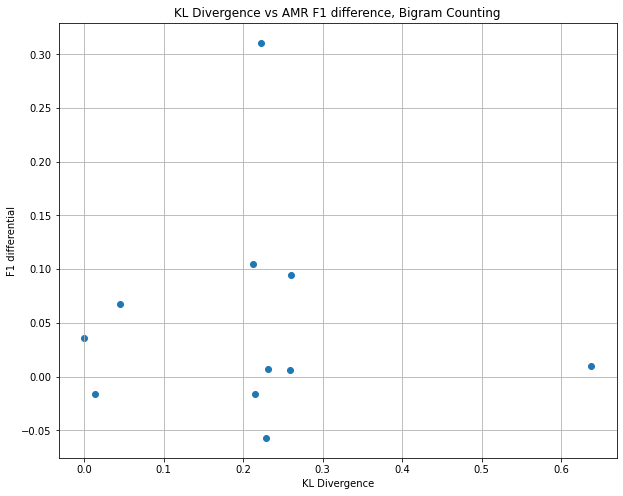

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("KL Divergence vs AMR F1 difference, Bigram Counting")
ax.grid()
ax.set_xlabel("KL Divergence")
ax.set_ylabel("F1 differential")

ax.scatter(x=joint_df["KL_divergence"], y=joint_df["diff"])